In [ ]:
import numpy as np
import pandas as pd
from os.path import splitext
from sklearn.model_selection import train_test_split
from tensorflow import expand_dims
import tensorflow as tf
from tensorflow.keras.utils import get_file
from tensorflow.keras.backend import set_floatx
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

In [ ]:
url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'
file_name = 'jena_climate_2009_2016.csv.zip'
zip = get_file(origin=url, fname=file_name, extract=True)

In [ ]:
df = pd.read_csv(splitext(zip)[0])
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.set_index('Date Time')
df.sort_index()
df = df[df['Date Time'].dt.year < 2014]
df = df[5::6] # slice data untuk mengurangi jumlah baris
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


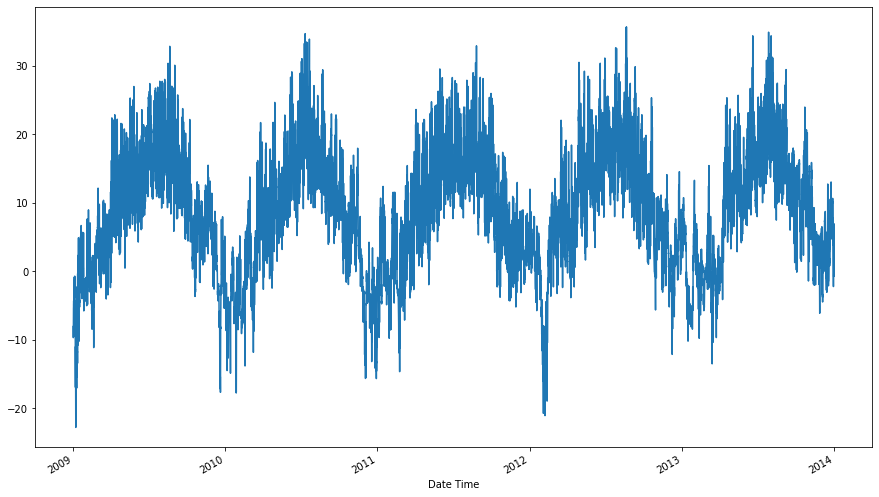

In [ ]:
plot_features = df['T (degC)']
plot_features.index = df['Date Time']
plt = plot_features.plot(subplots=True, figsize=(15, 9))

In [ ]:
date_time = df['T (degC)'].values
temp_celcius = df['T (degC)'].values

In [ ]:
df.shape[0]

43847

In [ ]:
x_trn, x_val, y_trn, y_val = train_test_split(temp_celcius, date_time, train_size=0.8, test_size = 0.2, shuffle = False)

In [ ]:
def timeseries_window(series, window_size, batch_size, shuffle_buffer):
  series = expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
set_floatx('float64')
trn_set = timeseries_window(x_trn, window_size=269, batch_size=200, shuffle_buffer=1000)
val_set = timeseries_window(x_val, window_size=269, batch_size=200, shuffle_buffer=1000)
model = Sequential(LSTM(60, return_sequences=True))
model.add(LSTM(60))
model.add(Dense(30, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1))

In [ ]:
MAE = 0.1*(df['T (degC)'].max() - df['T (degC)'].min())
print(MAE)

5.841


In [ ]:
class maeCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<MAE and logs.get('val_mae')<MAE):
      print("\n")
      print("\nmodel MAE < 10% data scale")
      self.model.stop_training = True

In [ ]:
model.compile(loss=Huber(), optimizer=SGD(learning_rate=0.0001, momentum=0.9), metrics=["mae"])
model.fit(trn_set, epochs=60, validation_data = val_set, callbacks=[maeCallback()])

Epoch 1/60
175/175 [==============================] - 246s 1s/step - loss: 9.2371 - mae: 9.7256 - val_loss: 8.4819 - val_mae: 8.9637
Epoch 2/60
175/175 [==============================] - 224s 1s/step - loss: 6.9210 - mae: 7.4032 - val_loss: 5.0378 - val_mae: 5.5185
Epoch 3/60
175/175 [==============================] - ETA: 0s - loss: 4.2652 - mae: 4.7446


MAE dari model < 10% skala data
175/175 [==============================] - 224s 1s/step - loss: 4.2652 - mae: 4.7446 - val_loss: 3.3485 - val_mae: 3.8180
